In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "alzheimers-dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "train"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
COLOR_MODE='rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 200
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    color_mode=COLOR_MODE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



Found 5753 files belonging to 4 classes.
Using 4603 files for training.
Found 5753 files belonging to 4 classes.
Using 1150 files for validation.


['C0_Mild_Demented', 'C1_Moderate_Demented', 'C2_Non_Demented', 'C3_Very_Mild_Demented']


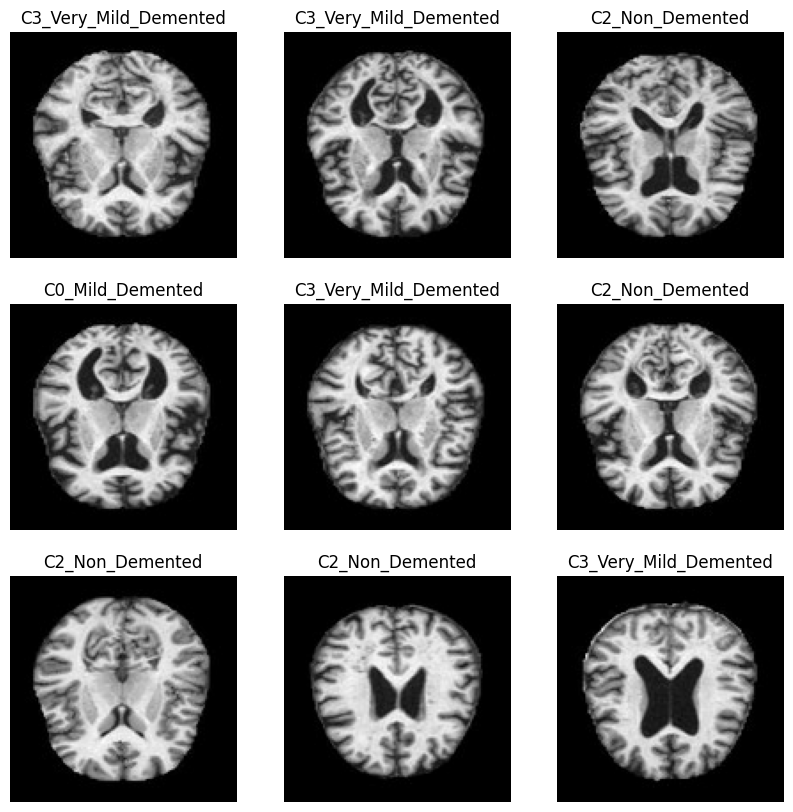

In [2]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    # print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    # keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomFlip("horizontal"),
    # keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.1, 0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [4]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     augmented_image = data_augmentation(images[i])
#     ax = plt.subplot(3, 3, i + 1)
#     # plt.imshow(augmented_image[0])
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.axis("off")


In [5]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(16, 3, padding="same", activation="relu", kernel_initializer='he_normal'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_normal'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_normal'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    # keras.layers.GlobalAveragePooling2D(),

    # keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_initializer='he_normal'),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation="softmax"),
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 128, 128, 3)       0         |
|                                                               |
| rescaling (Rescaling)     (None, 128, 128, 3)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                      

In [6]:
train_ds
im_ext = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def hasExt(filename):
    for ext in im_ext:
        if filename.endswith(ext):
            return True
    return False

dirs = []
n_samples = 0
path = TRAINING_FOLER
for i in os.listdir(path):
    if os.path.isdir(os.path.join(path, i)):
        dirs.append(path+"/"+i)
# init dictionary with values 0
d = {}
for i in range(len(dirs)):
    d[i] = 0
# d = {0:0, 1:0, 2:0, 3:0}

for i in dirs:
    for j in os.listdir(i):
        imgPaths = i+"/"+j
        if os.path.isfile(imgPaths) and hasExt(imgPaths):
            n_samples += 1
            if "C0" in i:
                d[0] += 1
            elif "C1" in i:
                d[1] += 1
            elif "C2" in i:
                d[2] += 1
            else:
                d[3] += 1
                
n_classes = len(dirs)
class_weights1 = {}
for i in range(n_classes):
    n_samples_i = d[i]
    wi = n_samples / (n_classes * n_samples_i)
    class_weights1[i] = wi
print(dirs)
print(n_samples)
print(n_classes)
print(d)
# class_weights1 = {0: w0, 1: w1}
print(class_weights1)

['alzheimers-dataset/train/C0_Mild_Demented', 'alzheimers-dataset/train/C1_Moderate_Demented', 'alzheimers-dataset/train/C2_Non_Demented', 'alzheimers-dataset/train/C3_Very_Mild_Demented']
5753
4
{0: 810, 1: 56, 2: 2871, 3: 2016}
{0: 1.7756172839506172, 1: 25.683035714285715, 2: 0.5009578544061303, 3: 0.7134176587301587}


In [7]:
from sklearn.utils import class_weight

y_train = tf.concat(list(map(lambda x: x[1], train_ds)), axis=0)
class_weights2 = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.numpy())
class_weights2 = dict(zip(np.unique(y_train), class_weights2))
print(class_weights2)

{0: 1.7175373134328358, 1: 27.398809523809526, 2: 0.5040516863775734, 3: 0.7156405472636815}


In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
    class_weight=class_weights2,
)

Epoch 1/200
144/144 [==============================] - 8s 36ms/step - loss: 1.5566 - sparse_categorical_accuracy: 0.3619 - val_loss: 1.2963 - val_sparse_categorical_accuracy: 0.4626
Epoch 2/200
144/144 [==============================] - 4s 28ms/step - loss: 1.1270 - sparse_categorical_accuracy: 0.4169 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.4070
Epoch 3/200
144/144 [==============================] - 4s 28ms/step - loss: 0.6948 - sparse_categorical_accuracy: 0.6057 - val_loss: 0.8857 - val_sparse_categorical_accuracy: 0.5852
Epoch 4/200
144/144 [==============================] - 4s 28ms/step - loss: 0.4663 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.5067 - val_sparse_categorical_accuracy: 0.7783
Epoch 5/200
144/144 [==============================] - 4s 28ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.3586 - val_sparse_categorical_accuracy: 0.8530
Epoch 6/200
144/144 [==============================] - 4s 28ms/step - loss: 0.1595 - spars

Epochs run: 38


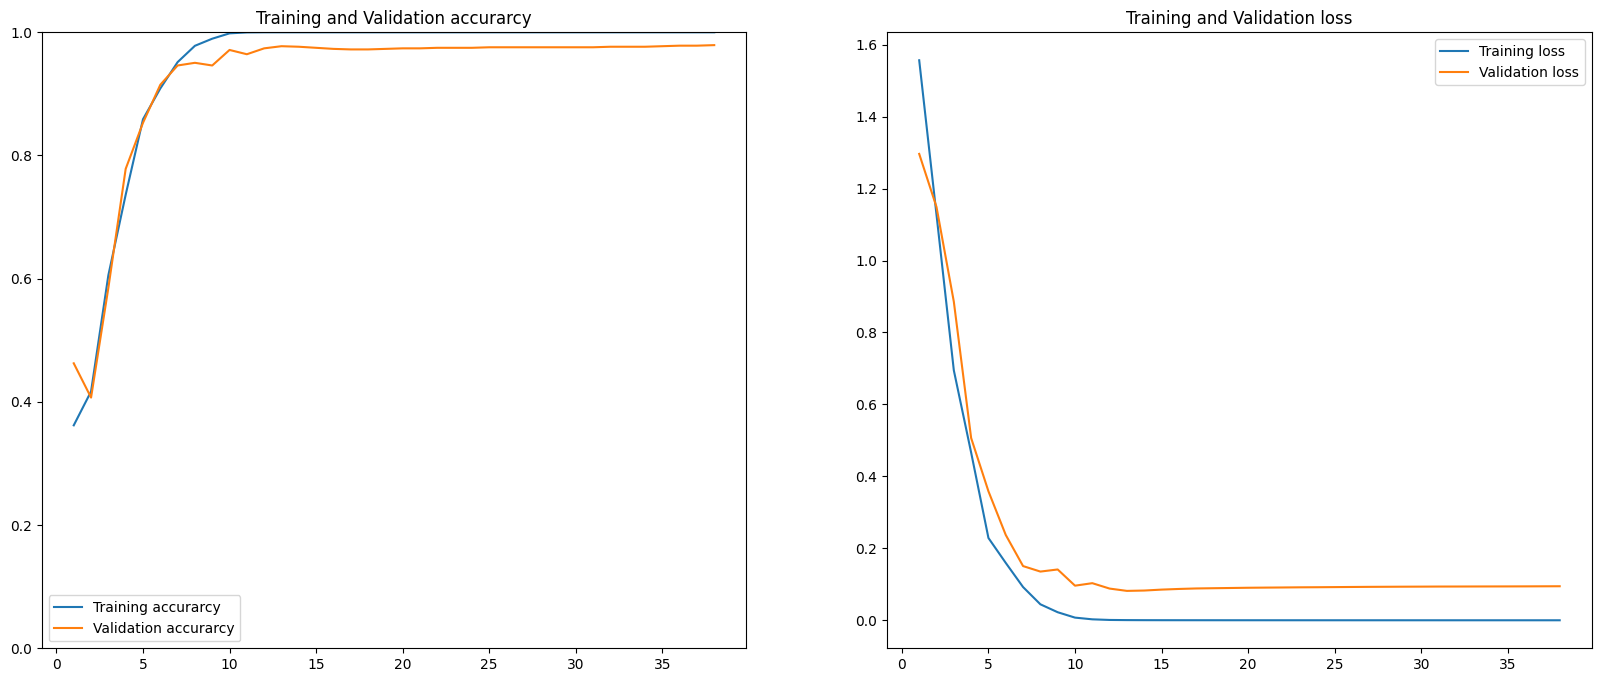

In [9]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [10]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE,)

results = model.evaluate(test_ds, verbose=0)

print("Test accuracy:", results[1]*100)
print("Test loss:", results[0]*100)

Found 647 files belonging to 4 classes.
Test accuracy: 94.43585872650146
Test loss: 15.92513918876648


Text(286.1666666666666, 0.5, 'True')

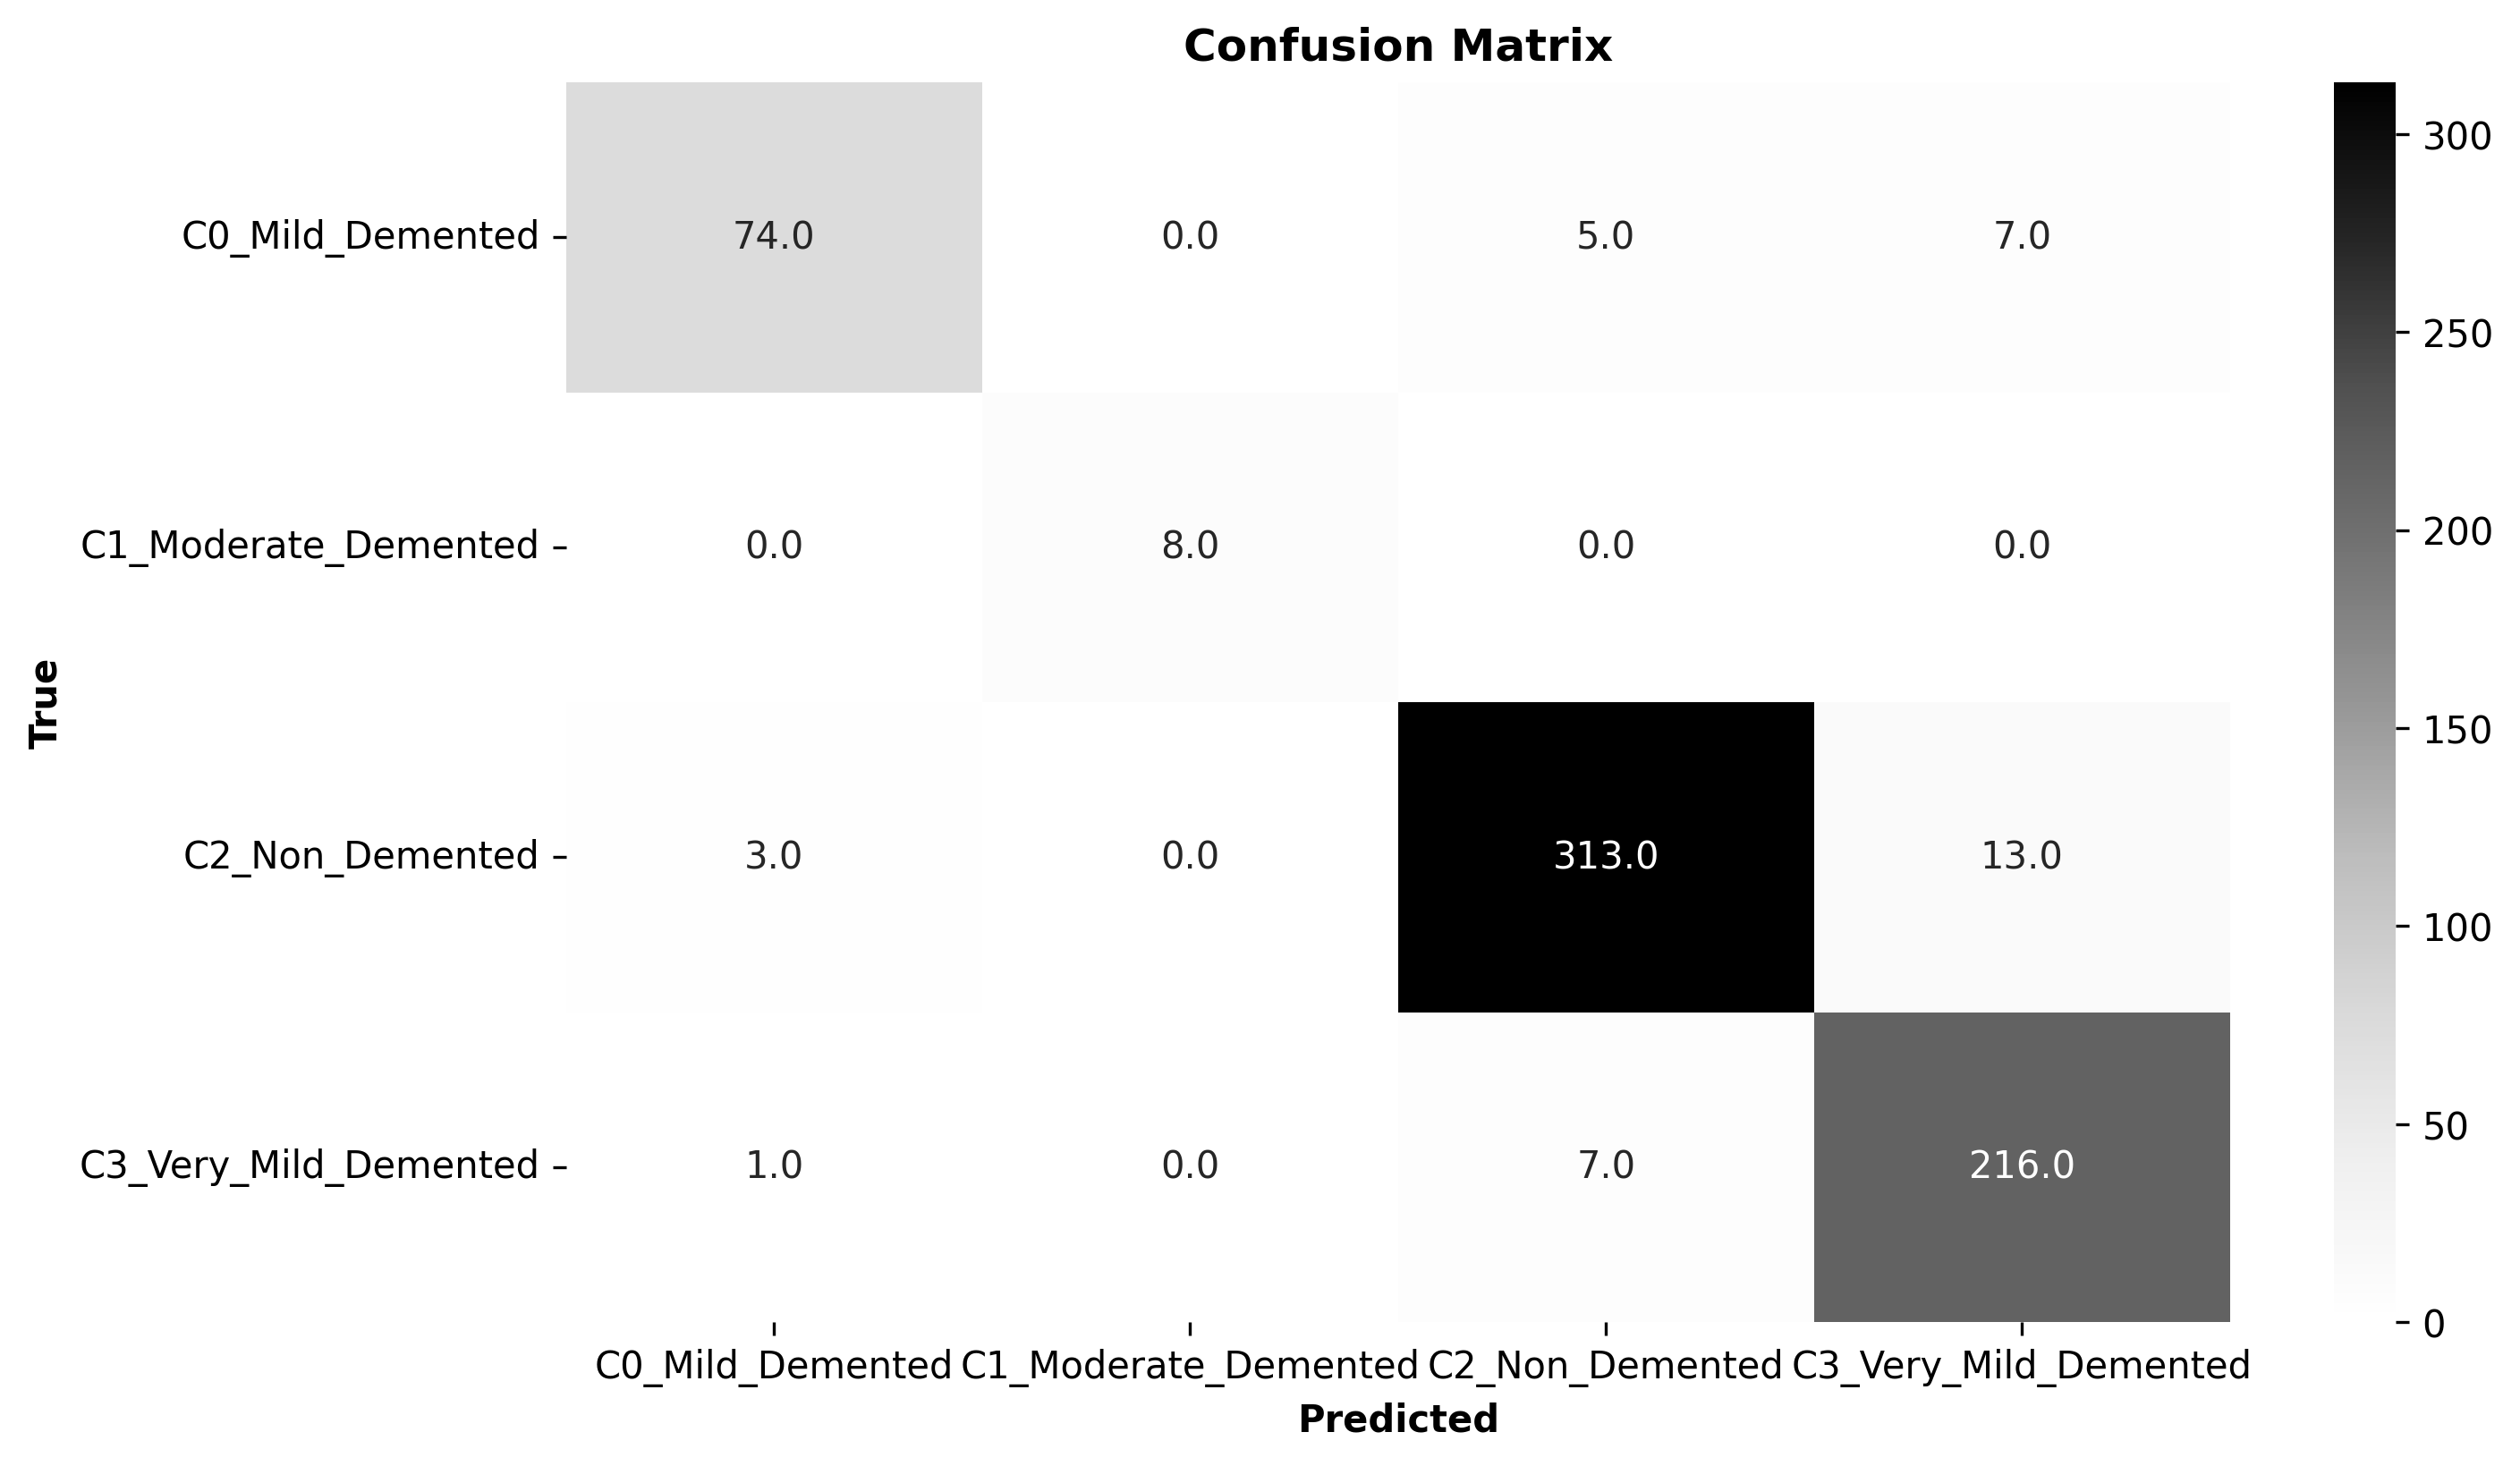

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd


predictions = []
labels = []

for X, y in test_ds.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)


cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")



In [12]:
print(classification_report(labels, predictions, target_names=class_names))

                       precision    recall  f1-score   support

     C0_Mild_Demented       0.95      0.86      0.90        86
 C1_Moderate_Demented       1.00      1.00      1.00         8
      C2_Non_Demented       0.96      0.95      0.96       329
C3_Very_Mild_Demented       0.92      0.96      0.94       224

             accuracy                           0.94       647
            macro avg       0.96      0.94      0.95       647
         weighted avg       0.95      0.94      0.94       647



In [13]:
# SAVING THE MODEL
# save the classification model
model.save("alzheimers-imb-cnn.h5")

In [14]:
import tensorflow as tf

model.save("alzheimers-imb-cnn.h5") 
loaded_model = tf.keras.models.load_model("alzheimers-imb-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


21/21 [==============================] - 1s 25ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9444
